In [1]:
import os
import glob
import datetime
import statistics
import numpy as np
import pandas as pd
import import_ipynb
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

In [2]:
from qp import get_stocks # 1/PBR + GP/A
#from ncav import get_stocks # NCAV

importing Jupyter notebook from qp.ipynb
importing Jupyter notebook from common.ipynb


In [4]:
DATA_DIR = 'data/daily/12-1'

In [5]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [6]:
df_account

,start_date,end_date,filepath
0,2002-12-02,2003-12-01,data/daily/12-1/2002-12-02.csv
1,2003-12-01,2004-12-01,data/daily/12-1/2003-12-01.csv
2,2004-12-01,2005-12-01,data/daily/12-1/2004-12-01.csv
3,2005-12-01,2006-12-01,data/daily/12-1/2005-12-01.csv
4,2006-12-01,2007-12-03,data/daily/12-1/2006-12-01.csv
5,2007-12-03,2008-12-01,data/daily/12-1/2007-12-03.csv
6,2008-12-01,2009-12-01,data/daily/12-1/2008-12-01.csv
7,2009-12-01,2010-12-01,data/daily/12-1/2009-12-01.csv
8,2010-12-01,2011-12-01,data/daily/12-1/2010-12-01.csv
9,2011-12-01,2012-12-03,data/daily/12-1/2011-12-01.csv


In [7]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.filepath, x.start_date), axis=1)

------------------------------
2002-12-02 data/daily/12-1/2002-12-02.csv
전체 1480
지주사, 금융사 제외 1384


common.ipynb:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "\n",


국외주식 제외 1384
가격정보 없는 기업 제외 1005
선정 기업 수 30
------------------------------
2003-12-01 data/daily/12-1/2003-12-01.csv
전체 1569
지주사, 금융사 제외 1472
국외주식 제외 1472
가격정보 없는 기업 제외 1067
선정 기업 수 30
------------------------------
2004-12-01 data/daily/12-1/2004-12-01.csv
전체 1619
지주사, 금융사 제외 1519
국외주식 제외 1519
가격정보 없는 기업 제외 1109
선정 기업 수 30
------------------------------
2005-12-01 data/daily/12-1/2005-12-01.csv
전체 1710
지주사, 금융사 제외 1609
국외주식 제외 1608
가격정보 없는 기업 제외 1180
선정 기업 수 30
------------------------------
2006-12-01 data/daily/12-1/2006-12-01.csv
전체 1762
지주사, 금융사 제외 1658
국외주식 제외 1657
가격정보 없는 기업 제외 1236
선정 기업 수 30
------------------------------
2007-12-03 data/daily/12-1/2007-12-03.csv
전체 1846
지주사, 금융사 제외 1738
국외주식 제외 1733
가격정보 없는 기업 제외 1314
선정 기업 수 30
------------------------------
2008-12-01 data/daily/12-1/2008-12-01.csv
전체 1933
지주사, 금융사 제외 1820
국외주식 제외 1811
가격정보 없는 기업 제외 1370
선정 기업 수 30
------------------------------
2009-12-01 data/daily/12-1/2009-12-01.csv
전체 1982
지주사, 금융사 제외 1865
국외주식 제외 1850


In [8]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률을 구한다.
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) # 가격 정보가 없을 경우 상폐
                end_price = end_price.iloc[0]
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

2002-12-02 ~ 2003-12-01 : 0.9981911631041717
2003-12-01 ~ 2004-12-01 : 1.3846665879044575
2004-12-01 ~ 2005-12-01 : 2.722825901276927
2005-12-01 ~ 2006-12-01 : 1.0471575021870987
2006-12-01 ~ 2007-12-03 : 1.9127765499508496
2007-12-03 ~ 2008-12-01 : 0.617469756022711
2008-12-01 ~ 2009-12-01 : 2.15783326352459
2009-12-01 ~ 2010-12-01 : 1.3460899299810478
2010-12-01 ~ 2011-12-01 : 1.317643957878179
2011-12-01 ~ 2012-12-03 : 2.056973994919848
2012-12-03 ~ 2013-12-02 : 1.108622045433008
2013-12-02 ~ 2014-12-01 : 1.3148900600707096
2014-12-01 ~ 2015-12-01 : 2.088130467742187
2015-12-01 ~ 2016-12-01 : 1.3556359465518548
2016-12-01 ~ 2017-12-01 : 1.363278602789481
2017-12-01 ~ 2018-12-03 : 1.3484664433838627
2018-12-03 ~ 2019-12-02 : 1.131059693621003


In [9]:
df_account['total'] = df_account['yield'].cumprod()

In [10]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/(i+1))

In [11]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [12]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [13]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

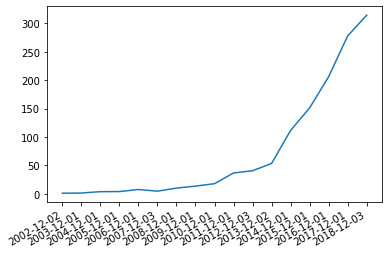

In [14]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

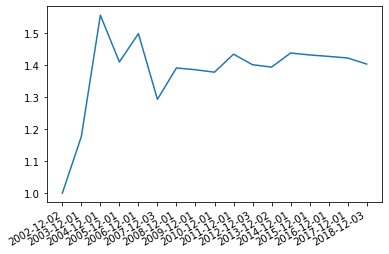

In [15]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['cagr'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [16]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,total,cagr,win_rate,best_corp,worst_corp,best_stock_code,worst_stock_code
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv,"[010600, 008900, 005610, 025880, 003230, 01457...",0.875945,"[0.8784313725490196, 0.27387387387387385, 0.64...",0.875945,0.875945,0.233333,1.558442,0.273874,027040,008900
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv,"[010600, 009460, 003680, 014100, 025880, 00409...",1.046675,"[0.7801339285714286, 0.8091286307053942, 1.791...",0.916829,0.957512,0.366667,4.596273,0.356618,006090,018680
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv,"[010600, 017680, 005320, 032860, 016920, 00409...",2.944093,"[1.6251788268955651, 1.826625386996904, 1.3725...",2.699231,1.392344,1.000000,21.000000,1.223958,050050,045060
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv,"[010600, 017680, 007980, 046310, 005320, 01447...",1.203979,"[2.0774647887323945, 1.9463276836158192, 1.164...",3.249818,1.342656,0.766667,3.633257,0.000000,014470,005320
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv,"[068290, 007980, 025880, 000440, 008110, 01692...",2.221812,"[2.0545977011494254, 2.2413793103448274, 1.916...",7.220484,1.484955,1.000000,4.810056,1.237762,004090,058220
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv,"[017680, 006060, 010600, 045060, 079650, 02588...",0.878090,"[0.5764966740576497, 0.7188118811881188, 0.051...",6.340236,1.360455,0.266667,2.258652,0.051104,041830,010600
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv,"[038320, 011080, 005320, 006060, 078520, 01457...",1.177229,"[0.367816091954023, 0.6288659793814433, 1.0273...",7.463908,1.332630,0.333333,4.037162,0.228853,078520,005360
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv,"[011080, 017680, 010470, 079650, 007980, 08879...",1.413679,"[0.8961748633879781, 1.1111111111111112, 1.666...",10.551569,1.342501,0.866667,3.868750,0.178649,048770,011300
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv,"[011080, 033340, 032860, 088790, 011090, 07965...",2.135537,"[0.9, 1.2244224422442245, 20.310344827586206, ...",22.533263,1.413559,0.666667,20.310345,0.107663,032860,024940
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv,"[011080, 038320, 033340, 044380, 091440, 01109...",1.423377,"[1.7073170731707317, 0.0, 1.1185983827493262, ...",32.073332,1.414537,0.633333,5.292683,0.000000,031860,038320


In [17]:
# df_account.to_csv('backtest-output/' + DATA_DIR + '.csv', index=False)

In [18]:
len(df_account)

17